<a href="https://colab.research.google.com/github/Nicholasyxx/UCLA-Trustworth-AI-Lab-Project/blob/main/MMD%5E2_function_with_PCA_and_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from IPython.display import Image, display
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

def calculate_mmd_squared(data1, data2, gamma):
    Kxx = rbf_kernel(data1, data1, gamma = gamma)
    Kyy = rbf_kernel(data2, data2, gamma = gamma)
    Kxy = rbf_kernel(data1, data2, gamma = gamma)

    n = len(data1)
    m = len(data2)

    np.fill_diagonal(Kxx, 0)
    np.fill_diagonal(Kyy, 0)

    mmd_squared = Kxx.sum() / (n * (n - 1)) + Kyy.sum() / (m * (m - 1)) - 2 * Kxy.sum() / (m * n)

    return mmd_squared

def preprocess_data(df1, df2, categorical_columns):
    numerical_columns = df1.select_dtypes(include=np.number).columns.tolist()

    # Check if DataFrame is empty
    if df1.empty or df2.empty:
        return None, None

    # Concatenate
    df_concat = pd.concat([df1, df2], keys=[0, 1])

    # One-hot encoding
    df_concat_encoded = pd.get_dummies(df_concat, columns=categorical_columns)

    # Split
    df1_encoded, df2_encoded = df_concat_encoded.xs(0), df_concat_encoded.xs(1)

    # Initialize
    ss = StandardScaler()

    # Normalize the numerical columns
    for column in numerical_columns:
        df1_encoded[column] = ss.fit_transform(df1_encoded[column].values.reshape(-1, 1)) #Based on real data, not let machine learn the synthetic data
        df2_encoded[column] = ss.transform(df2_encoded[column].values.reshape(-1, 1))

    # Convert the datasets to numpy arrays
    df1_transformed = df1_encoded.values
    df2_transformed = df2_encoded.values

    return df1_transformed, df2_transformed



# For categorical data
def plot_distribution(df1, df2, column):
    plt.figure(figsize=(10, 6))
    df1[column].value_counts(normalize=True).sort_index().plot(kind='bar', color='blue', alpha=0.5, position=1, width=0.4)
    df2[column].value_counts(normalize=True).sort_index().plot(kind='bar', color='red', alpha=0.5, position=0, width=0.4)
    plt.legend(['Real', 'Synthetic'])
    plt.title(f'Distribution of {column}')
    plt.show()


# For numerical data
def plot_histogram(df1, df2, column):
    plt.figure(figsize=(10, 6))
    plt.hist(df1[column], bins=30, alpha=0.5, label='Real')
    plt.hist(df2[column], bins=30, alpha=0.5, label='Synthetic')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'Histogram of {column}')
    plt.show()

def plot_boxplot(df1, df2, column):
    plt.figure(figsize=(10, 6))
    plt.boxplot([df1[column], df2[column]], labels=['Real', 'Synthetic'])
    plt.ylabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

def plot_kde(df1, df2, column):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df1[column], label='Real')
    sns.kdeplot(df2[column], label='Synthetic')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'Kernel Density Estimate of {column}')
    plt.show()

def plot_cdf(df1, df2, column):
    plt.figure(figsize=(10, 6))
    plt.hist(df1[column], bins=30, cumulative=True, alpha=0.5, density=True, label='Real')
    plt.hist(df2[column], bins=30, cumulative=True, alpha=0.5, density=True, label='Synthetic')
    plt.xlabel(column)
    plt.ylabel('CDF')
    plt.legend()
    plt.title(f'Cumulative Distribution Function of {column}')
    plt.show()


# For the full data downscaling process
def plot_pca(df1, df2):
    pca = PCA(n_components=2)
    df1_pca = pca.fit_transform(df1) # new coordinate system to which the original data can be transformed
    df2_pca = pca.transform(df2)

    plt.figure(figsize=(10, 6))
    plt.scatter(df1_pca[:, 0], df1_pca[:, 1], color='blue', alpha=0.5, label='Real')
    plt.scatter(df2_pca[:, 0], df2_pca[:, 1], color='red', alpha=0.5, label='Synthetic')
    plt.legend()
    plt.title('PCA plot')
    plt.show()



def plot_tsne(df1, df2, column_value, mmd_squared, file_path):
    # perplexity_value = min(df1.shape[0], df2.shape[0], 30) - 1
    # tsne = TSNE(n_components=2, perplexity=perplexity_value)

    if df1.shape[0] < 30 or df2.shape[0] < 30:
        print(f"Skipping t-SNE plot for {column_value} due to insufficient data.")
        return

    tsne = TSNE(n_components=2, perplexity = 30)
    df1_tsne = tsne.fit_transform(df1)
    df2_tsne = tsne.fit_transform(df2)

    plt.figure(figsize=(10, 6))
    plt.scatter(df1_tsne[:, 0], df1_tsne[:, 1], color='blue', alpha=0.5, label='Real')
    plt.scatter(df2_tsne[:, 0], df2_tsne[:, 1], color='red', alpha=0.5, label='Synthetic')
    plt.legend()
    plt.title(f'{column_value} t-SNE plot (MMD^2 = {mmd_squared})')

    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory




def compare_datasets(file1, file2, categorical_columns):
    # Load the data
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Preprocess the data
    df1_transformed, df2_transformed = preprocess_data(df1, df2, categorical_columns)

    # MMD^2
    gamma = 1.0
    mmd_squared = calculate_mmd_squared(df1_transformed, df2_transformed, gamma)
    print('MMD^2:', mmd_squared)

    # Plot distributions
    for column in df1.columns:
        if column in categorical_columns:
            plot_distribution(df1, df2, column)
        else:
            plot_histogram(df1, df2, column)
            plot_boxplot(df1, df2, column)
            plot_kde(df1, df2, column)
            plot_cdf(df1, df2, column)


    #PCA
    plot_pca(df1_transformed, df2_transformed)

    #t-SNE
    plot_tsne(df1_transformed, df2_transformed)




def calculate_mmd_values(file1, file2, categorical_columns, column):
    # Load the data
    df1 = pd.read_csv(file1, nrows=1000).fillna(0)
    df2 = pd.read_csv(file2, nrows=1000).fillna(0)

    # Get unique values in the specified column
    unique_values = df1[column].unique()

    # Prepare a dictionary to store the file path
    results = {}

    # For each unique value in the column
    for value in unique_values:
        # Filter the data for the specified value
        df1_filtered = df1[df1[column] == value]
        df2_filtered = df2[df2[column] == value]

        # Preprocess the filtered data
        df1_filtered_transformed, df2_filtered_transformed = preprocess_data(df1_filtered, df2_filtered, categorical_columns)
        if df1_filtered_transformed is None or df2_filtered_transformed is None:
            continue


        # MMD^2
        gamma = 1.0
        mmdSquared = calculate_mmd_squared(df1_filtered_transformed, df2_filtered_transformed, gamma)

        # t-SNE plot:
        # 1: Naming the path of each tsne plot
        # 2: Using this file path and other parameter to generate real tsne plot.
        # 3: Store all
        filePath = f"tsne_{file2}_{column}_{value}.png"
        plot_tsne(df1_filtered_transformed, df2_filtered_transformed, column_value=f"{value} in {column}", mmd_squared = mmdSquared, file_path = filePath)

        # Store the result of file path
        results[value] = filePath

    return results


    '''
    For example:
     {
      'Male': 'tsne_census1000_CTGAN_CTGAN_300_1_synthetic_sex_Male.png',
      'Female': 'tsne_census1000_CTGAN_CTGAN_300_1_synthetic_sex_Female.png'
     }

    '''



# compare all of the synthetic files with real file,
def compare_all_files(real_file, synthetic_files, categorical_columns, column):

    # Prepare a dataframe to store the results
    df_results = pd.DataFrame()

    # For each synthetic file
    for synthetic_file in synthetic_files:
      mmd_squared = calculate_mmd_values(real_file, synthetic_file, categorical_columns, column) # For example: mmd_squared = {
                                                                                                 #                              'Female': 'tsne_file1_Female.png',
                                                                                                 #                              'Male': 'tsne_file1_Male.png'
                                                                                                 #                            }



      # Add the results to the dataframe
      df_results = df_results.append(pd.DataFrame(mmd_squared, index=[synthetic_file])) # For example: 	                Female	                    Male
                                                                                        #                   1.0	    tsne_file1_Female.png	    tsne_file1_Male.png


                                                                                        # Append: add row by row

    return df_results




In [ ]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
compare_datasets('census1000.csv', 'census1000_CTGAN_CTGAN_300_3.0_synthetic.csv', categorical_columns)


FileNotFoundError: ignored

<ipython-input-1-76491c9398af>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_encoded[column] = ss.fit_transform(df1_encoded[column].values.reshape(-1, 1)) #Based on real data, not let machine learn the synthetic data
<ipython-input-1-76491c9398af>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_encoded[column] = ss.transform(df2_encoded[column].values.reshape(-1, 1))
<ipython-input-1-76491c9398af>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

census1000_CTGAN_CTGAN_300_1_synthetic.csv
 Male


<ipython-input-1-76491c9398af>:235: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.DataFrame(mmd_squared, index=[synthetic_file])) # For example: 	                Female	                    Male


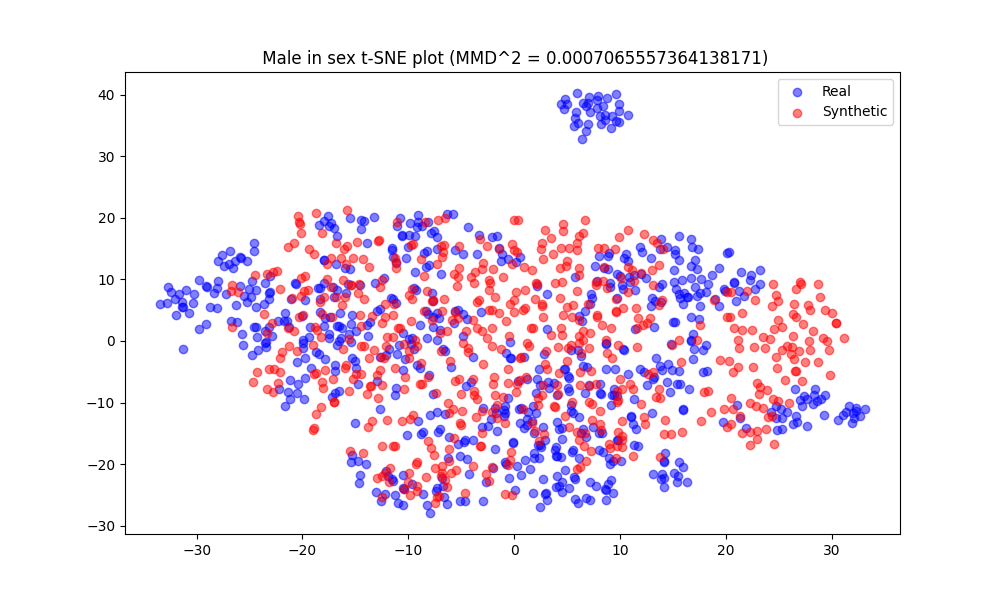

 Female


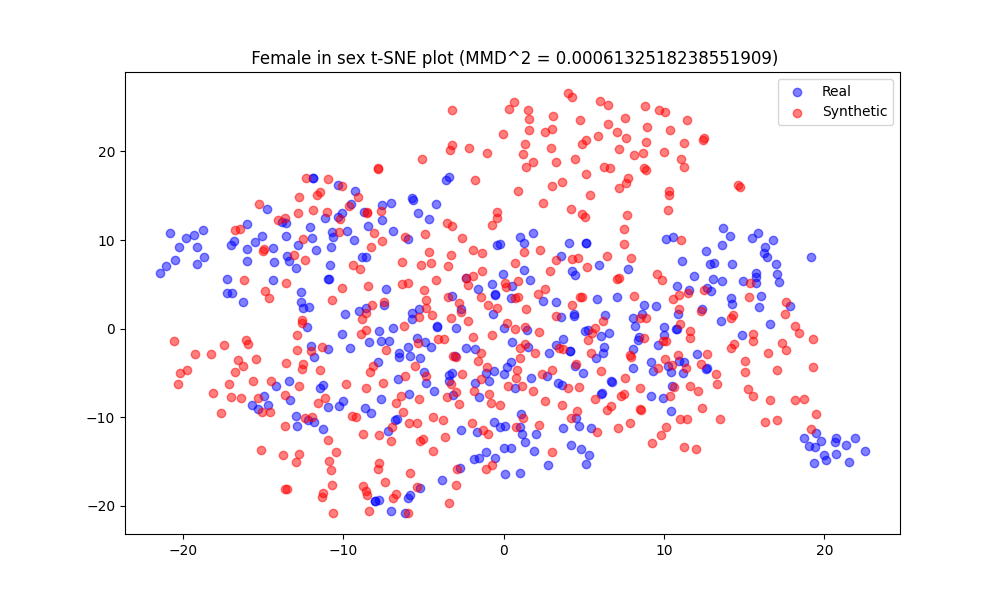

census1000_CTGAN_CTGAN_300_3.0_synthetic.csv
 Male


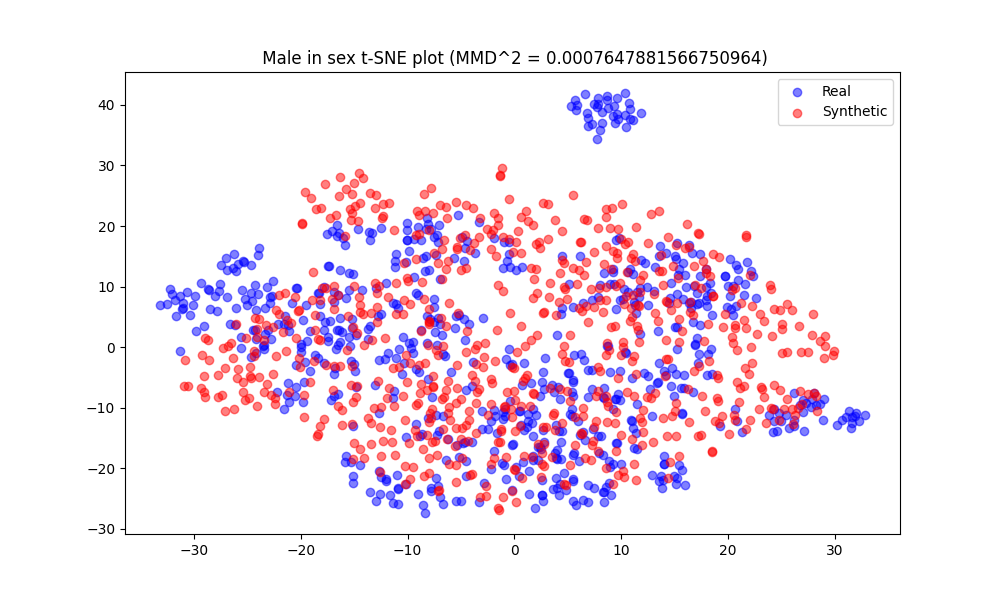

 Female


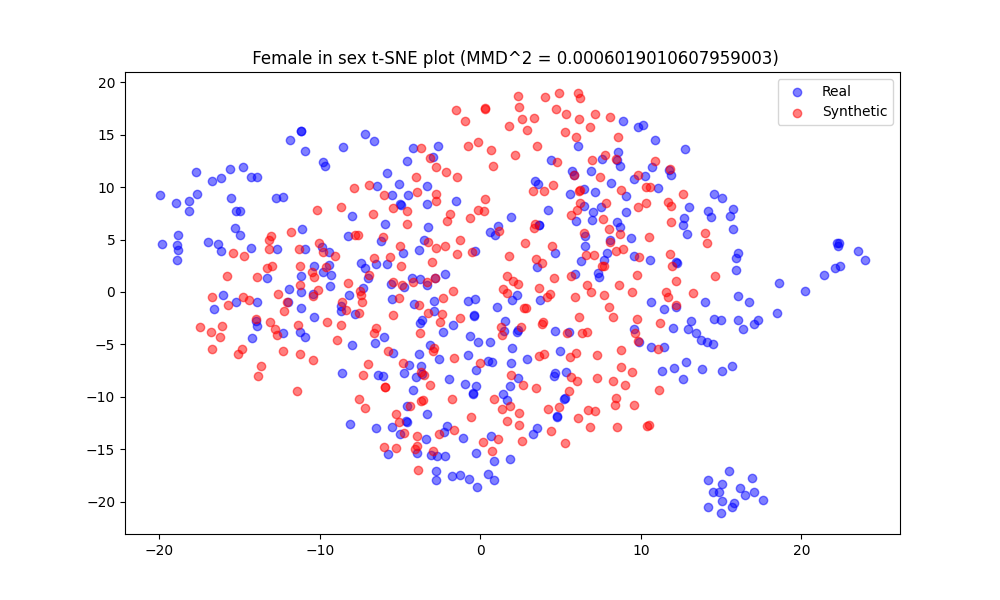

census1000_CTGAN_CTGAN_300_5.0_synthetic.csv
 Male


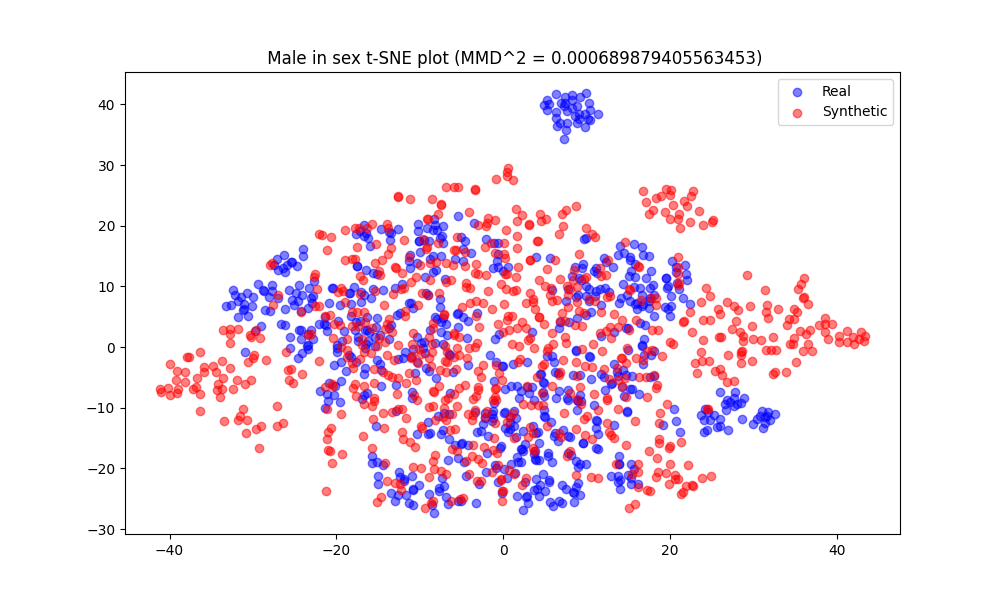

 Female


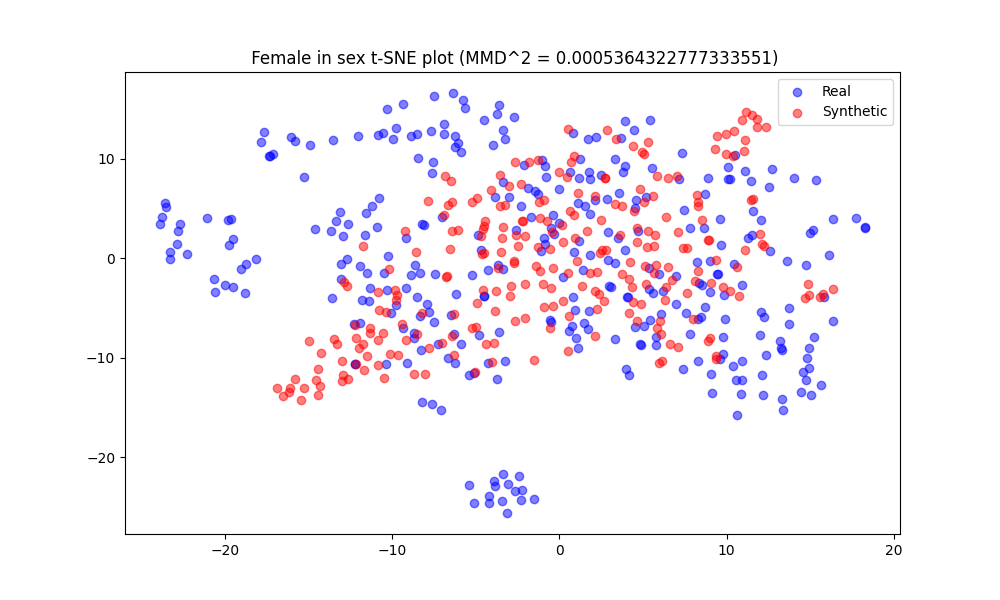

In [ ]:
# Use the functions
real_file = 'census1000.csv'
synthetic_files = ['census1000_CTGAN_CTGAN_300_1_synthetic.csv', 'census1000_CTGAN_CTGAN_300_3.0_synthetic.csv', 'census1000_CTGAN_CTGAN_300_5.0_synthetic.csv']
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
column = 'sex'


df_results = compare_all_files(real_file, synthetic_files, categorical_columns, column)


# Display images
for synthetic_file in synthetic_files:
    print(synthetic_file)
    for value in df_results.columns:
        print(value)

        # Use Image() to display image of the path of each tsne plot
        display(Image(df_results.loc[synthetic_file, value]))

<ipython-input-3-5a7f0a1bb1d7>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_encoded[column] = ss.fit_transform(df1_encoded[column].values.reshape(-1, 1)) #Based on real data, not let machine learn the synthetic data
<ipython-input-3-5a7f0a1bb1d7>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_encoded[column] = ss.transform(df2_encoded[column].values.reshape(-1, 1))
<ipython-input-3-5a7f0a1bb1d7>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

med_merge_trimmed_CPAR_synthetic.csv
Other


<ipython-input-3-5a7f0a1bb1d7>:249: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.DataFrame(mmd_squared, index=[synthetic_file])) # For example: 	                Female	                    Male


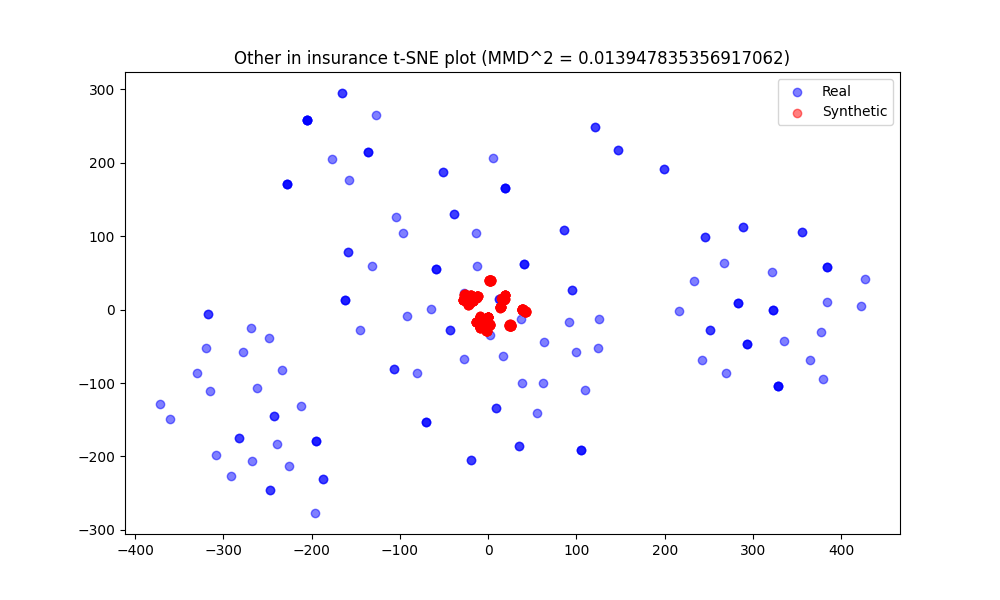

Medicare


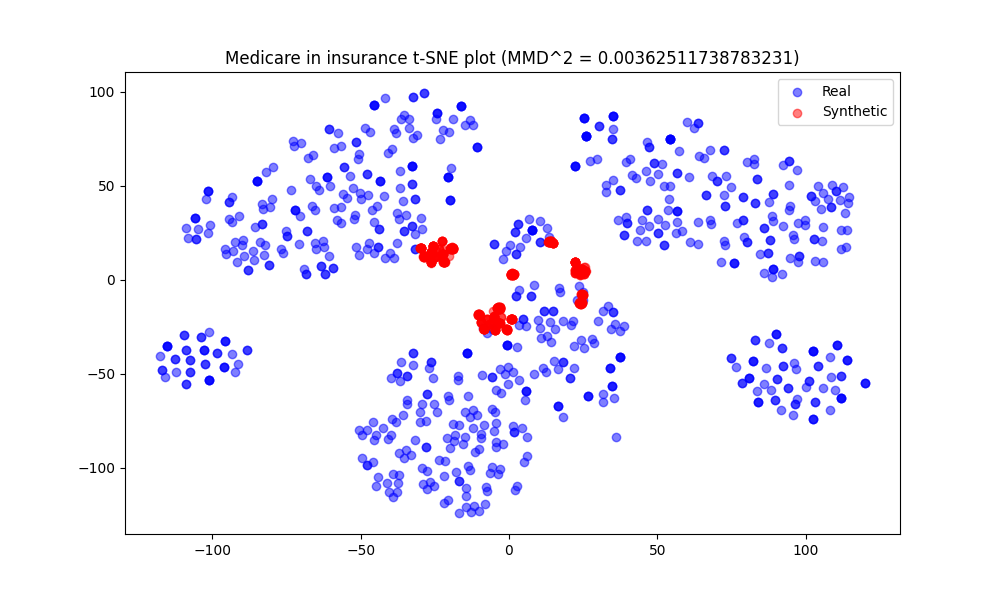

Medicaid


FileNotFoundError: ignored

FileNotFoundError: ignored

<IPython.core.display.Image object>

med_merge_trimmed_CTabformer_MedMergeCTabFormer_5_1_synthetic.csv
Other


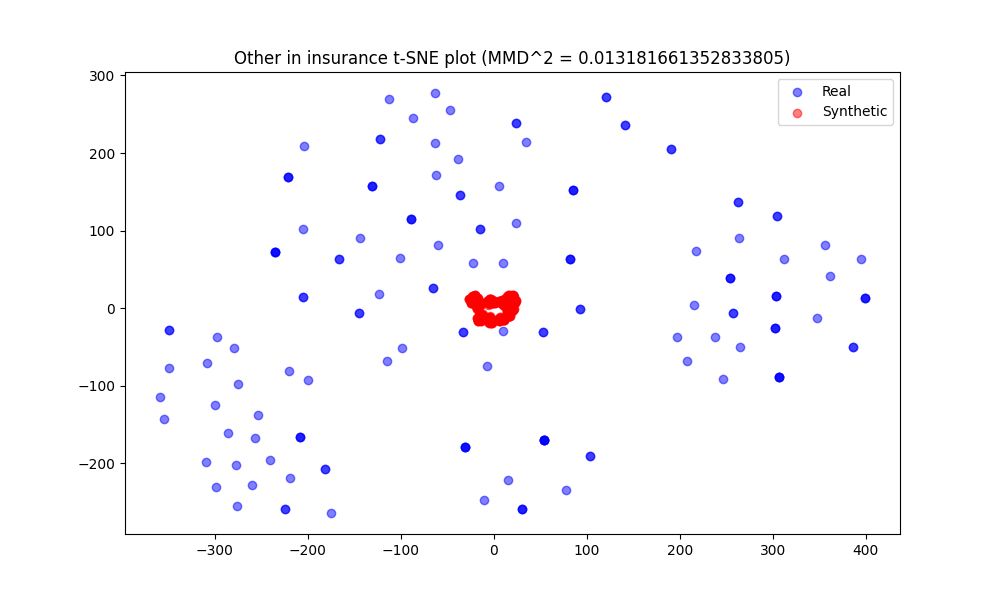

Medicare


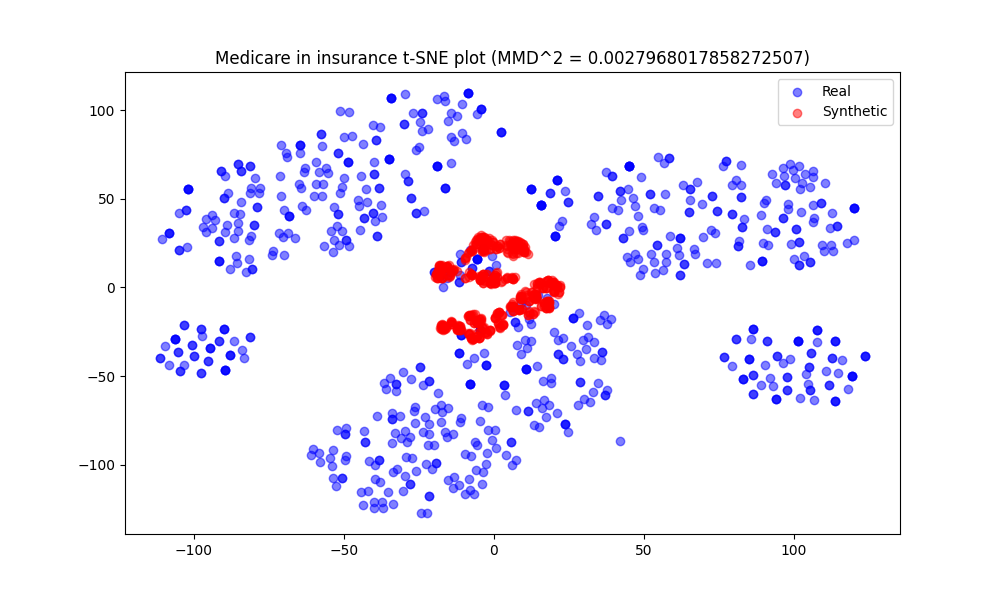

Medicaid


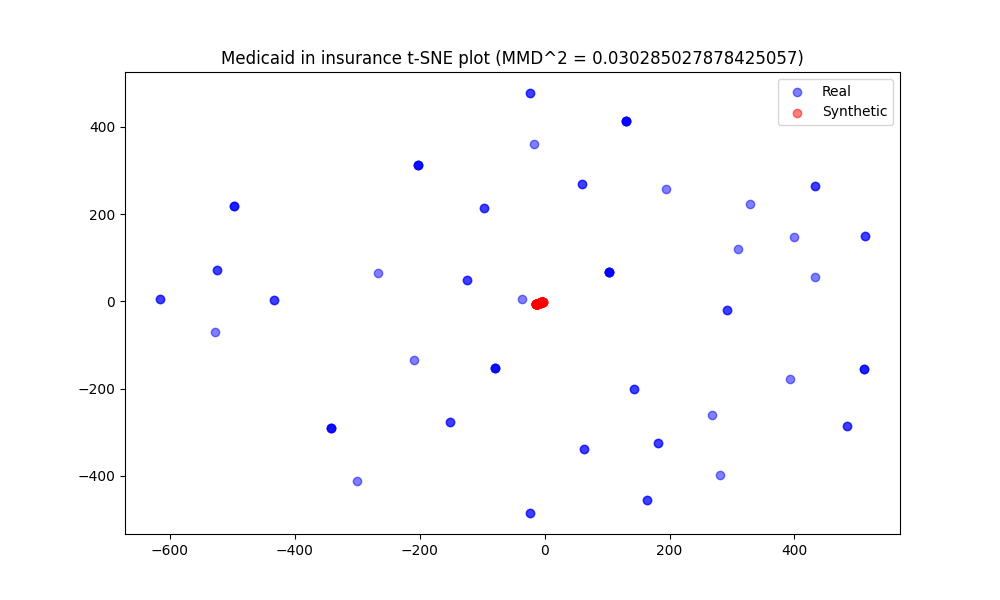

med_merge_trimmed_CTabformer_MedMergeCTabFormer_50_1_head8_layer12_synthetic.csv
Other


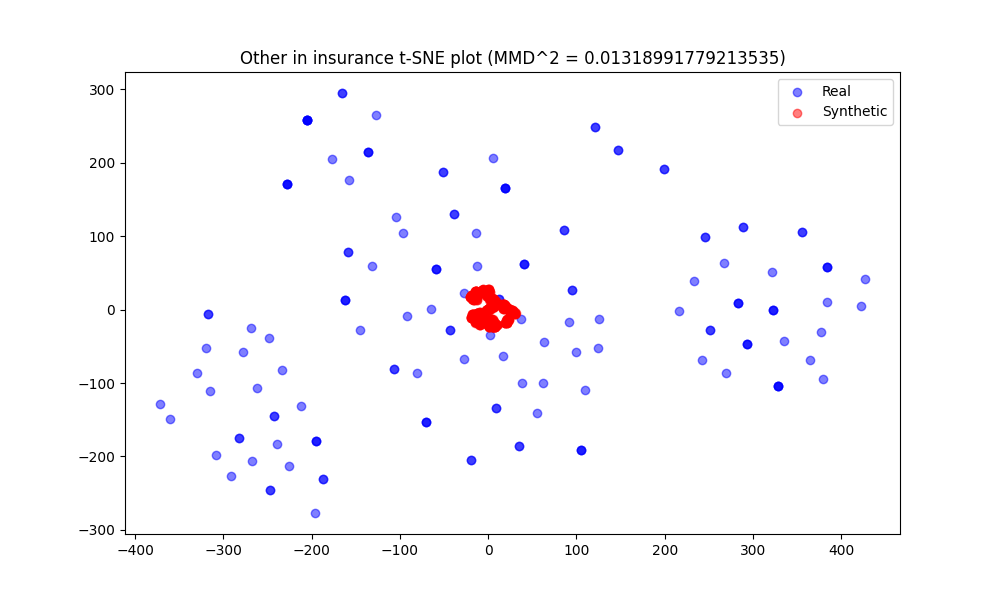

Medicare


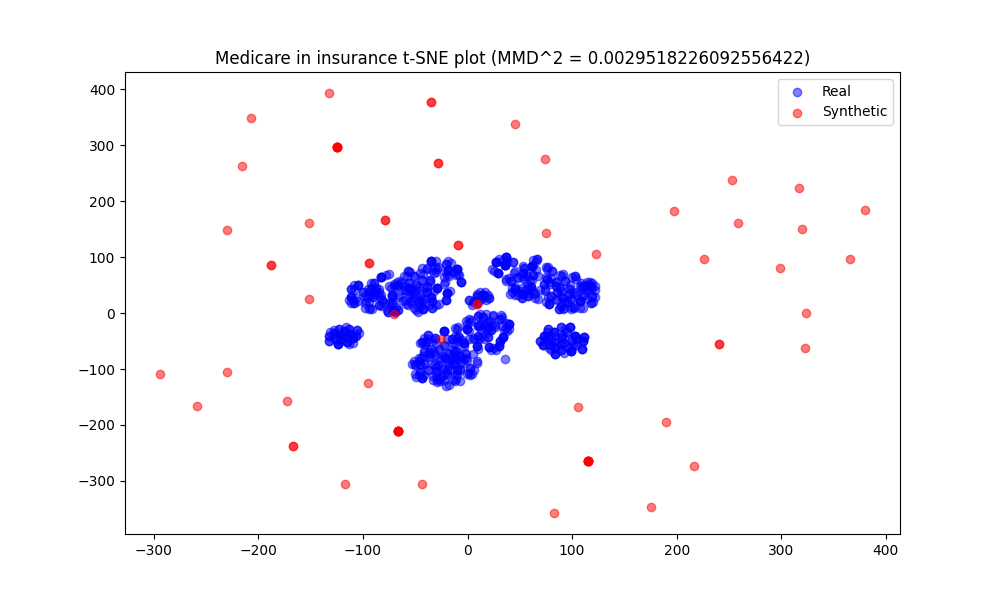

Medicaid


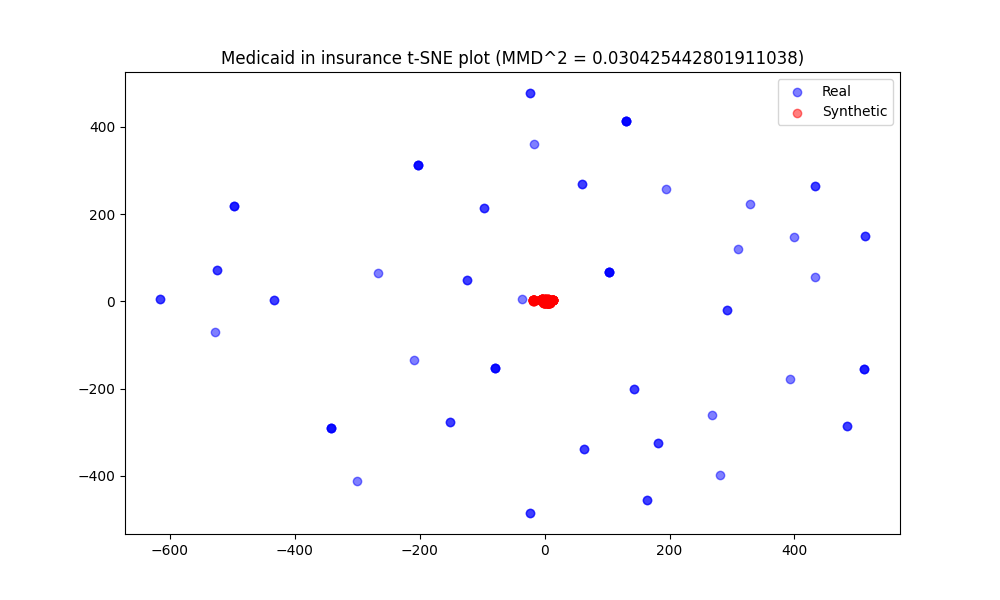

med_merge_trimmed_CTGAN_CTGANTime_300_1_synthetic.csv
Other


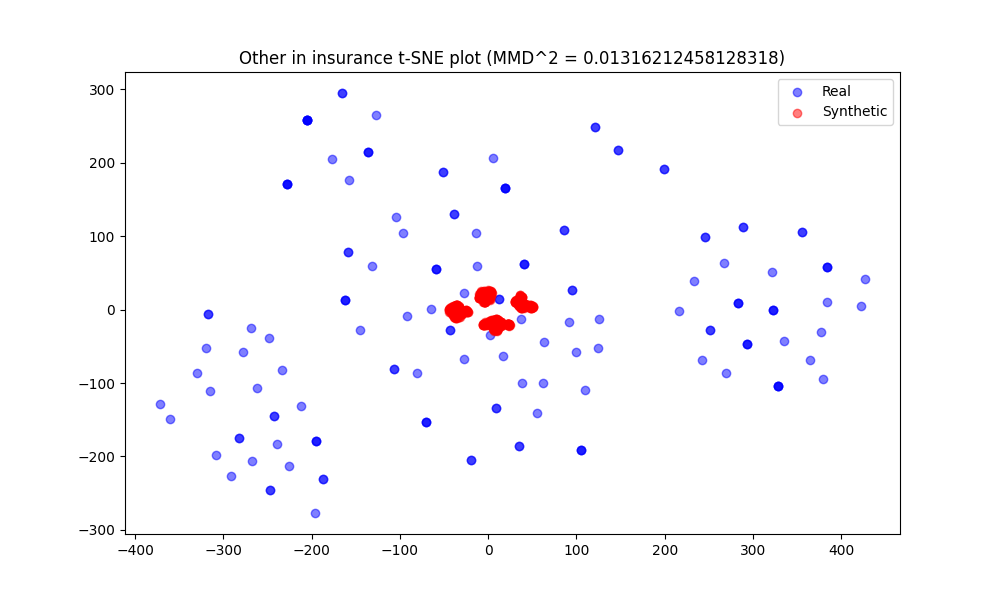

Medicare


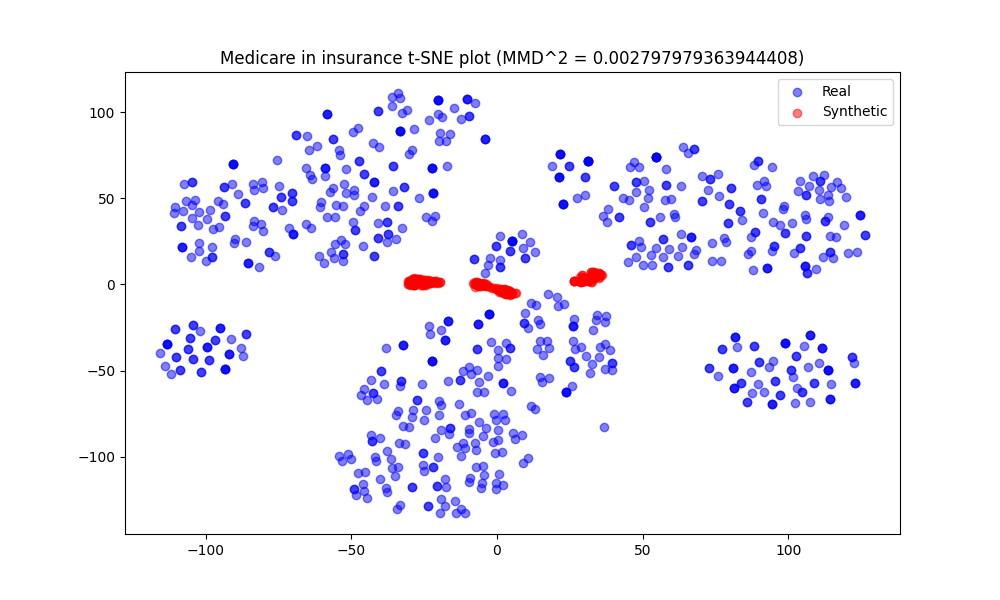

Medicaid


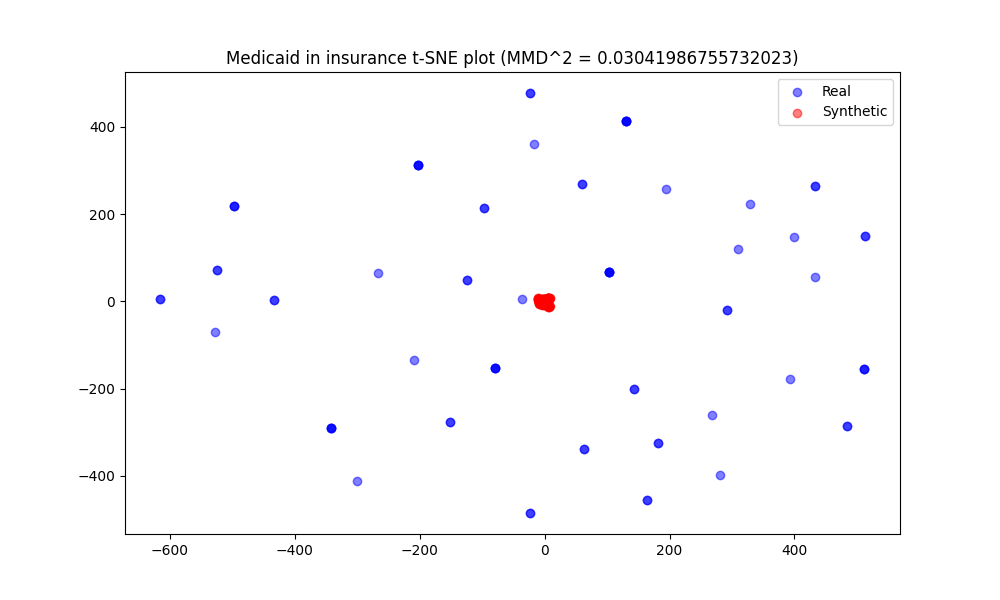

In [ ]:
# Use the functions
real_file = 'med_merge_trimmed_bootstrap.csv'
synthetic_files = ['med_merge_trimmed_CPAR_synthetic.csv', 'med_merge_trimmed_CTabformer_MedMergeCTabFormer_5_1_synthetic.csv', 'med_merge_trimmed_CTabformer_MedMergeCTabFormer_50_1_head8_layer12_synthetic.csv', 'med_merge_trimmed_CTGAN_CTGANTime_300_1_synthetic.csv']
categorical_columns = ['starttime', 'stoptime', 'drug_name', 'gender', 'ethnicity', 'insurance']
column = 'insurance'


df_results = compare_all_files(real_file, synthetic_files, categorical_columns, column)


# Display images
for synthetic_file in synthetic_files:
    print(synthetic_file)
    for value in df_results.columns:
        print(value)

        # Use Image() to display image of the path of each tsne plot
        display(Image(df_results.loc[synthetic_file, value]))

In [ ]:
# Use the functions
real_file = 'EcommerceNoID_distilgpt2_100.csv'
synthetic_files = ['EcommerceShortNoID_CTGAN_CTGANTrend_300_1_synthetic.csv', 'EcommerceShortNoID_PATECTGAN_CTGANTime_300_1_synthetic.csv', 'EcommerceShortNoID_PATECTGAN_CTGANTime_300_3.0_synthetic.csv', 'EcommerceShortNoID_PATECTGAN_CTGANTime_300_5.0_synthetic.csv', 'EcommerceShortNoID_PATECTGAN_CTGANTime_300_10.0_synthetic.csv']
categorical_columns = ['InvoiceDate', 'Country']
column = 'Country'


df_results = compare_all_files(real_file, synthetic_files, categorical_columns, column)


# Display images
for synthetic_file in synthetic_files:
    print(synthetic_file)
    for value in df_results.columns:
        print(value)

        # Use Image() to display image of the path of each tsne plot
        display(Image(df_results.loc[synthetic_file, value]))

<ipython-input-1-ccd3e3b1596f>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_encoded[column] = ss.fit_transform(df1_encoded[column].values.reshape(-1, 1)) #Based on real data, not let machine learn the synthetic data
<ipython-input-1-ccd3e3b1596f>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_encoded[column] = ss.transform(df2_encoded[column].values.reshape(-1, 1))
<ipython-input-1-ccd3e3b1596f>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Skipping t-SNE plot for Finland in Country due to insufficient data.


ValueError: ignored

<ipython-input-19-1b9fd3de237d>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_encoded[column] = ss.fit_transform(df1_encoded[column].values.reshape(-1, 1)) #Based on real data, not let machine learn the synthetic data
<ipython-input-19-1b9fd3de237d>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_encoded[column] = ss.transform(df2_encoded[column].values.reshape(-1, 1))
<ipython-input-19-1b9fd3de237d>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

bank-full_CTGAN_CTGANTime_300_1_synthetic.csv
primary


<ipython-input-19-1b9fd3de237d>:243: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(pd.DataFrame(mmd_squared, index=[synthetic_file])) # For example: 	                Female	                    Male


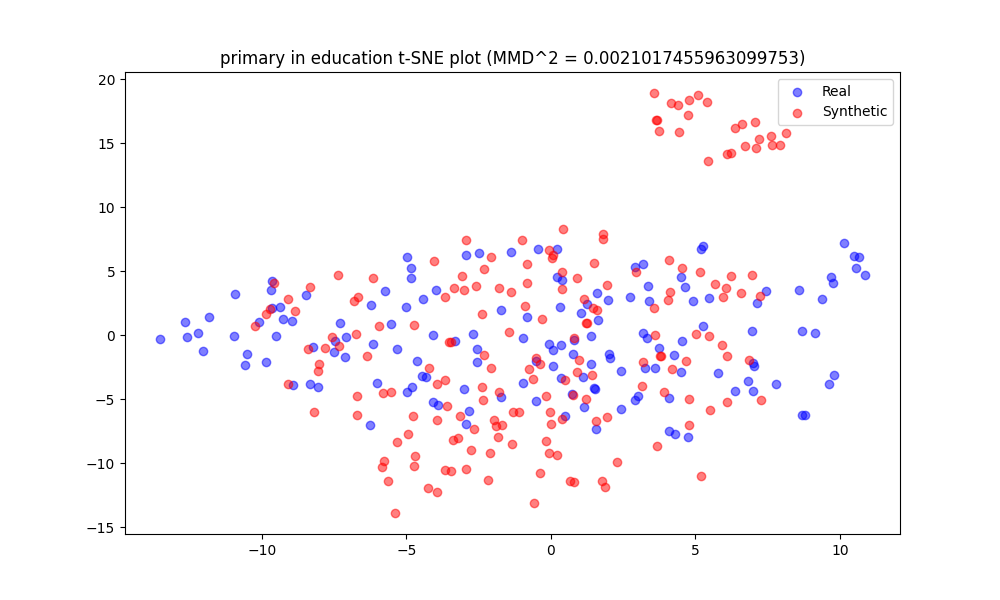

secondary


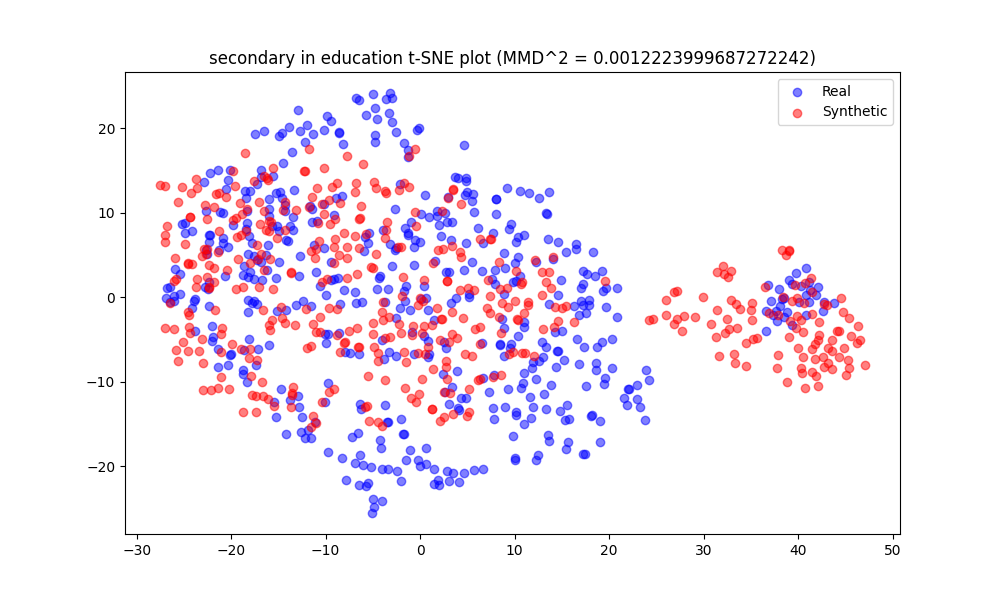

tertiary


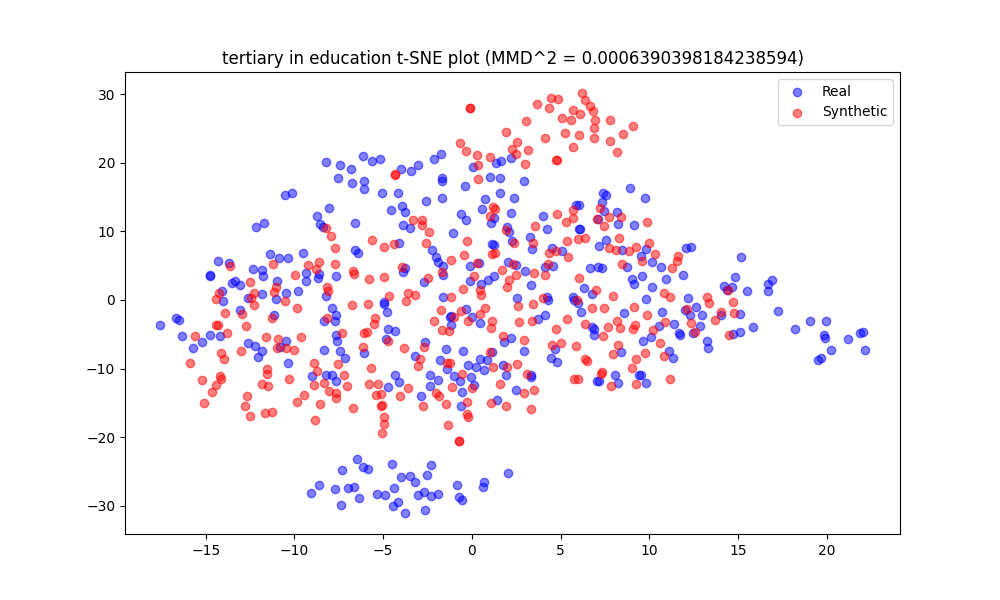

unknown


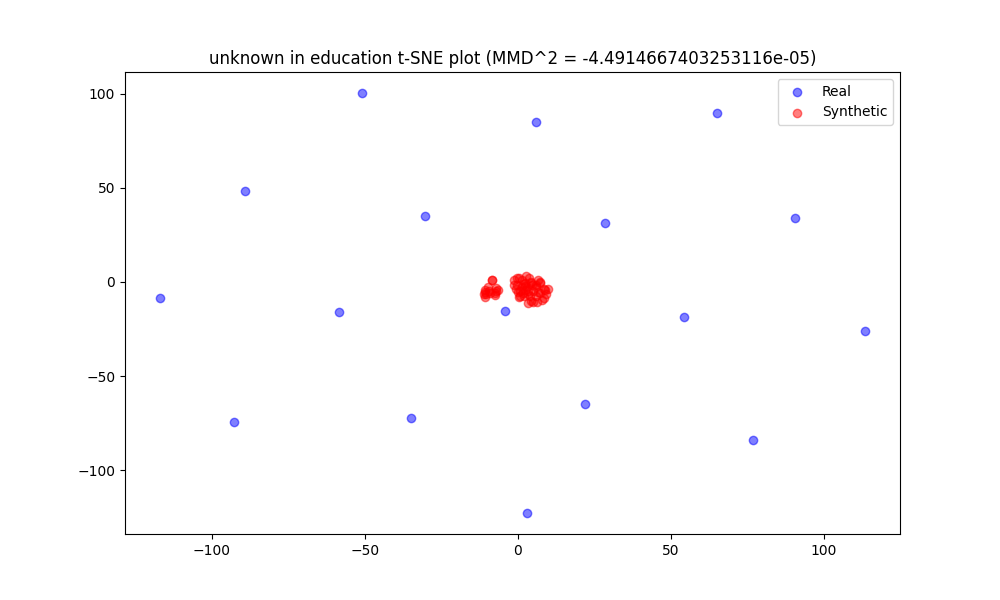

In [ ]:
# Use the functions
real_file = 'bank_distilgpt2_100.csv'
synthetic_files = ['bank-full_CTGAN_CTGANTime_300_1_synthetic.csv']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
column = 'education'


df_results = compare_all_files(real_file, synthetic_files, categorical_columns, column)


# Display images
for synthetic_file in synthetic_files:
    print(synthetic_file)
    for value in df_results.columns:
        print(value)

        # Use Image() to display image of the path of each tsne plot
        display(Image(df_results.loc[synthetic_file, value]))